# 初始生成对抗网络

**环境：**
- python==3.6
- tensorflow==2.4.1

**生成对抗网络，英文是Generative adversarial network，简称GAN**
- 生成：
> 产生一堆东西，例如产生一张图片、一段文字或一段视频。
- 对抗：
> 生活中随处可见，同事之间的竞争，警察与匪徒之间的竞争。

## GAN的结构

GAN与普通的网络不同，主要由两个主要网络构成：
- 一个是Generator Network，称为生成网络或生成器
- 一个是Discriminator Network，称为判别网络或判别器
*所以GAN的核心逻辑就是生成器和判别器的相互对抗*

>eg:
（判别器）项目经理跟你说了一个方案，（生成器）你不断的提交结果给他，他每一次提出修改意见，直到最后你完成了一个都满意的方案。
这个可能有点抽象，还有就是假钞和验钞机的例子，直到假钞验钞机辨别不出来就成功了。

## GAN的用途

- GAN常见的用途就是生成非常真实的图片，可以为训练其他类型的神经网络提供数据源，如生成路况数据，让无人车在虚拟环境中测试
- GAN还可以用于声音领域，如将一个人的声音转变成另一个人的声音
- 在视频领域中，GAN可以生成预测视频中下一帧的画面，我们以后有没有可能看到一部由GAN生成的电影？
- 进行图片风格迁移，比如换脸技术，图片变成油画

## GAN的结构
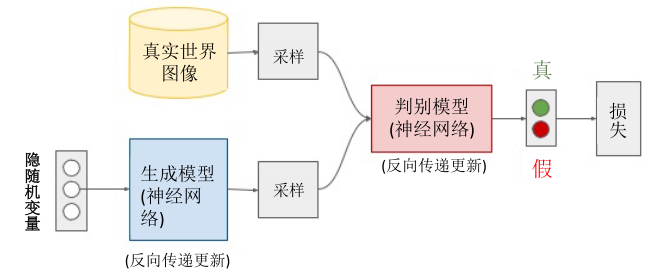

GAN的训练一开始是训练判别器，目的是让判别器获得一个“标准”，也就是说先知道怎么判断一个好的产品，当训练完判别器后，知道了如何定义一个好的标准，再训练生成器，生成产品后由判别器给产品打分，与真实值的差距就是损失，生成器通过不断的学习来弥补损失，使自己的产品更逼真。

## GAN的训练步骤

- 初始化生成器和判别器，参数随机生成
- 在每一轮训练中，执行以下步骤

> 1. 固定生成器参数，训练判别器的参数

>>a．因为生成器的参数被固定了，此时生成器的参数没有收敛，生成器通过未收敛参数生成的图片就不会特别真实。

>>b．从准备好的图片数据库中选择一组真实图片数据。

>>c．通过上面两步操作，此时就有了两组数据：一组是生成器生成的图片数据；另一组是真实图片数据。通过这两组数据训练判别器，让其对真实图片赋予高分，给生成图片赋予低分。

> 2.固定判别器，训练生成器

>>a.随机生成一组噪声喂给生成器，让生成器生成一张图片

>>b.将生成的图片传入判别器中，判别器会给该图片一个分数，生成器的目标使使这个分数更高

## GAN的公式
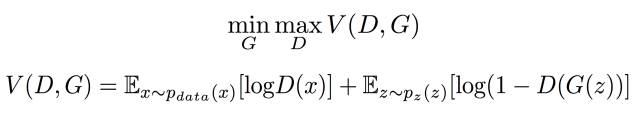

*D定义为判别器，G定义为生成器。第一步要训练判别器，所以有了第一个部分，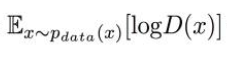，期望x从$P_data$分布中获取，x表示真实数据，$P_data$表示真实数据的分布，所以期待D(X)接近1*

*后半部分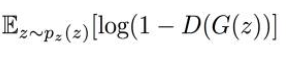表示期望Z从$P_z(z)$分布中获取；z表示生成数据$P_z(z)$表示生成数据的分布*

在训练生成器的过程中，想让$G(z)$接近0则loss值更小，GAN的训练两部分别针对公式的两个部分，互不影响。
- 在第一步时候尽量让loss值变大，第二部让loss值变小

## TensorFlow实现朴素GAN

### 朴素GAN生成MNIST数据集

In [2]:
# 导入库
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

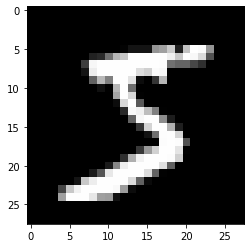

In [3]:
mnist=tf.keras.datasets.mnist
(x_,y_),(x_1,y_1)=mnist.load_data('./MNIST')
# 以灰度图的形式读入
plt.imshow(x_[0], cmap='Greys_r')
plt.show()

In [4]:
print(type(x_[0]))
print(x_[0].shape)

<class 'numpy.ndarray'>
(28, 28)


训练

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape


In [5]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [6]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [7]:
# 生成器

def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

In [8]:
# 构造判别器

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [9]:
# 搭建整个模型

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [10]:
# 训练GAN

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    mnist=tf.keras.datasets.mnist
    (X_train, _), (_, _) = mnist.load_data('./MNIST')
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, real)
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print("%d [D loss: %f, acc.: %.2f%%] [G loss:%f]"%(iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            sample_images(generator)

In [11]:
def sample_images (generator,image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 *gen_imgs +0.5
    fig, axs = plt.subplots(image_grid_rows,image_grid_columns,figsize=(4,4),sharey=True,sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt +=1

1000 [D loss: 0.012059, acc.: 100.00%] [G loss:5.706644]
2000 [D loss: 0.020676, acc.: 100.00%] [G loss:5.093577]
3000 [D loss: 0.106617, acc.: 96.88%] [G loss:7.146727]
4000 [D loss: 0.110318, acc.: 96.09%] [G loss:4.225368]
5000 [D loss: 0.195206, acc.: 91.80%] [G loss:4.506620]
6000 [D loss: 0.142877, acc.: 94.53%] [G loss:4.924820]
7000 [D loss: 0.375484, acc.: 84.38%] [G loss:2.959124]
8000 [D loss: 0.170229, acc.: 93.75%] [G loss:3.822861]
9000 [D loss: 0.468704, acc.: 79.30%] [G loss:3.314807]
10000 [D loss: 0.416569, acc.: 83.59%] [G loss:3.402380]
11000 [D loss: 0.319609, acc.: 83.98%] [G loss:3.763397]
12000 [D loss: 0.441802, acc.: 80.86%] [G loss:3.113745]
13000 [D loss: 0.567380, acc.: 76.56%] [G loss:3.040237]
14000 [D loss: 0.510444, acc.: 78.91%] [G loss:2.702926]
15000 [D loss: 0.386428, acc.: 83.98%] [G loss:2.485862]
16000 [D loss: 0.389039, acc.: 82.81%] [G loss:2.454142]
17000 [D loss: 0.482096, acc.: 78.52%] [G loss:2.748819]
18000 [D loss: 0.412623, acc.: 78.91%]

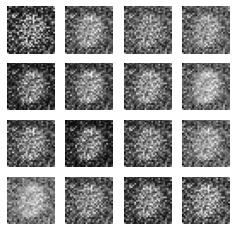

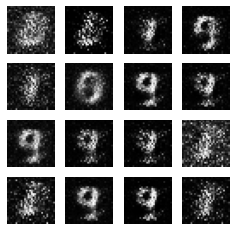

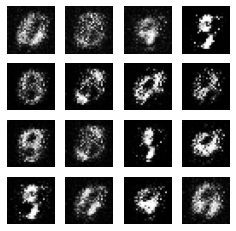

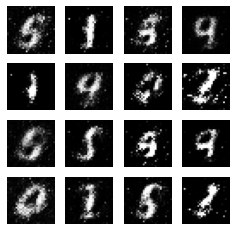

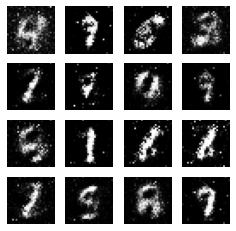

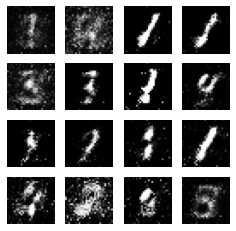

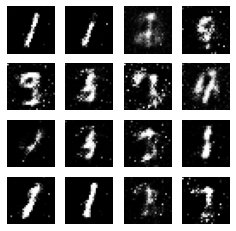

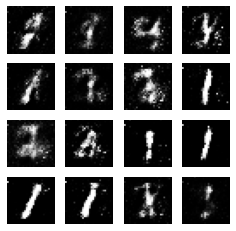

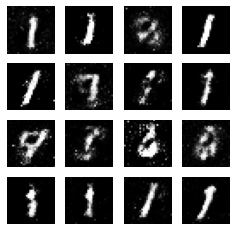

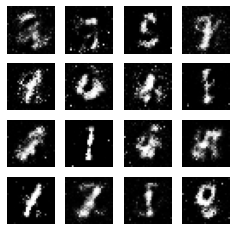

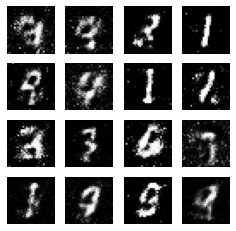

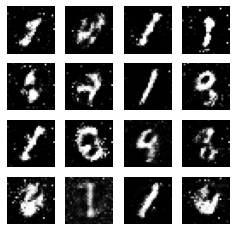

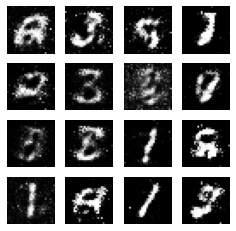

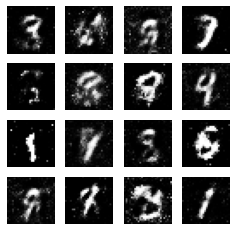

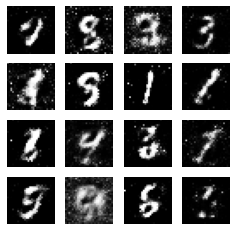

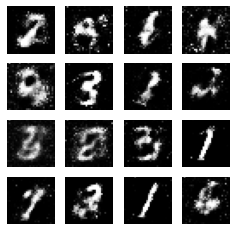

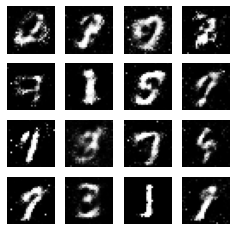

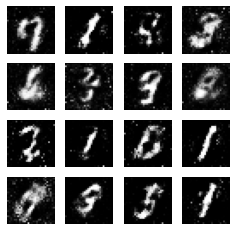

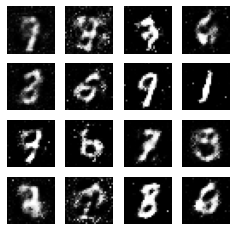

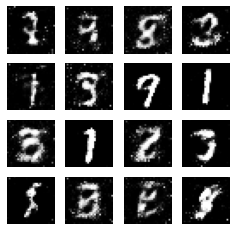

In [12]:
iterations  = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)

## 小结

本次实验的GAN中生成器和判别器都是比较简单的网络，最后可以基本实现手写数字图片的生成，算是初步了解了一下GAN的搭建和训练的整个过程。